### FRED® API

The FRED® API is a web service that allows developers to write programs and build applications that retrieve economic data from the FRED® and ALFRED® websites hosted by the Economic Research Division of the Federal Reserve Bank of St. Louis. Requests can be customized according to data source, release, category, series, and other preferences.

For documentation regarding Fred API, refer to the the following link https://fred.stlouisfed.org/docs/api/fred/#API 

For exploring FRED data, refer to the following link https://fred.stlouisfed.org/

Importing the necessary libraries to perform analysis on FRED data

In [3]:
import json
import requests
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt

Connecting to the FRED® API using private API tokens. Any individual will be able to generate their private Keys after creating an account in the website.

The Private API keys are then stored in a json file which is then processed.

In [4]:
with open('APIsecret.json', 'r') as f:
    secrets = json.load(f)

api_key = secrets["api_key"]

### Connceting to FRED through API

In order to bring amount code structure and reduce making API calls seperately a Class "FredPy" class has been utlized. 

Classes provide a means of bundling data and functionality together. Creating a new class creates a new type of object, allowing new instances of that type to be made. Each class instance can have attributes attached to it for maintaining its state. Class instances can also have methods (defined by its class) for modifying its state.

In [5]:
class FredPy:

    def __init__(self, token=None):
        """
        Fredpy Class
        
        This class connects to FRED API using private API keys as stored in the Json file. 
        
        """
        self.token = token
        self.url = "https://api.stlouisfed.org/fred/series/observations" + \
                    "?series_id={seriesID}&api_key={key}&file_type=json" + \
                    "&observation_start={start}&observation_end={end}&units={units}"

    def set_token(self, token):
        self.token = token


    def get_series(self, seriesID, start, end, units):
        
        """
        This function makes the primary call to FRED API and reformats the data to extract the required observation data
        
        If the response was successful, extract the data from it, otherwise raise an exception error for Bad Response from API.
        This allows for graceful exit of the function.
        
        The extracted data are warngled using lambda function over assign method to convert oclumns to datetime and float
        data type. 
        
        """

        # The URL string with the values inserted into it
        url_formatted = self.url.format(
            seriesID=seriesID, start=start, end=end, units=units, key=self.token
        )

        response = requests.get(url_formatted)

        if(self.token):
            if(response.status_code == 200):
                data = pd.DataFrame(response.json()['observations'])[['date', 'value']]\
                        .assign(date = lambda cols: pd.to_datetime(cols['date']))\
                        .assign(value = lambda cols: cols['value'].astype(float))\
                        .rename(columns = {'value': seriesID})

                return data

            else:
                raise Exception("Bad response from API, status code = {}".format(response.status_code))
        else:
            raise Exception("You did not specify an API key.")

In [6]:
fredpy = FredPy()

fredpy.set_token(api_key)


cpiLessFoodEnergy = fredpy.get_series(
    seriesID="CORESTICKM159SFRBATL", 
    start = '1970-01-01',
    end = '2022-03-01', 
    units = 'lin'
)

cpicore = fredpy.get_series(
    seriesID="MEDCPIM158SFRBCLE", 
    start = '1983-01-01',
    end = '2022-03-01', 
    units = 'lin'
)

ppifreghttruck = fredpy.get_series(
    seriesID="PCU484121484121", 
    start = '2000-01-01',
    end = '2022-03-01', 
    units = 'lin'
)



### CPI (excluding Food and Energy)

The Sticky Price Consumer Price Index (CPI) is calculated from a subset of goods and services included in the CPI that change price relatively infrequently. 

Because these goods and services change price relatively infrequently, they are thought to incorporate expectations about future inflation to a greater degree than prices that change on a more frequent basis. One possible explanation for sticky prices could be the costs firms incur when changing price.

In the next analysis we explore how Consumer Price Index has changed over the years and try to understand the significance of the current scenario of high inflation.

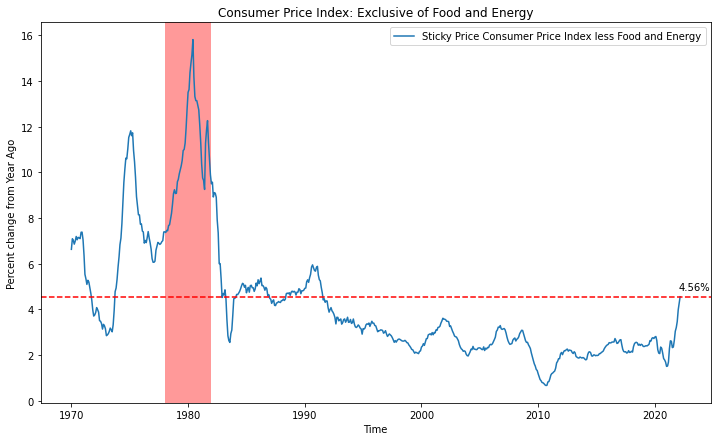

In [7]:
plt.figure(figsize = (12, 7))

plt.plot(cpiLessFoodEnergy['date'], cpiLessFoodEnergy['CORESTICKM159SFRBATL'], label='Sticky Price Consumer Price Index less Food and Energy')


plt.axhline(y = 4.551815, color = 'r', linestyle = '--')
plt.title("Consumer Price Index: Exclusive of Food and Energy")
plt.axvspan(dt.date(1978,1,3), dt.date(1982,1,3), color='r', alpha=0.4, lw=0)
plt.text(dt.date(2022,1,3), 4.851815,'4.56%')
plt.ylabel('Percent change from Year Ago')
plt.xlabel('Time')
plt.legend()
plt.show()

### Core CPI (Median Consumer Price Index)

CPI (excluding energy and food) does not present the complete picture of economical inflation. So lets explore to see the changes in the Core CPI.

Median Consumer Price Index (CPI) is a measure of core inflation calculated the Federal Reserve Bank of Cleveland and the Ohio State University. Median CPI was created as a different way to get a 'Core CPI' measure, or a better measure of underlying inflation trends. To calculate the Median CPI, the Cleveland Fed analyzes the median price change of the goods and services published by the BLS. 

The median price change is the price change that’s right in the middle of the long list of all of the price changes. This series excludes 49.5% of the CPI components with the highest and lowest one-month price changes from each tail of the price-change distribution resulting in a Median CPI Inflation Estimate.

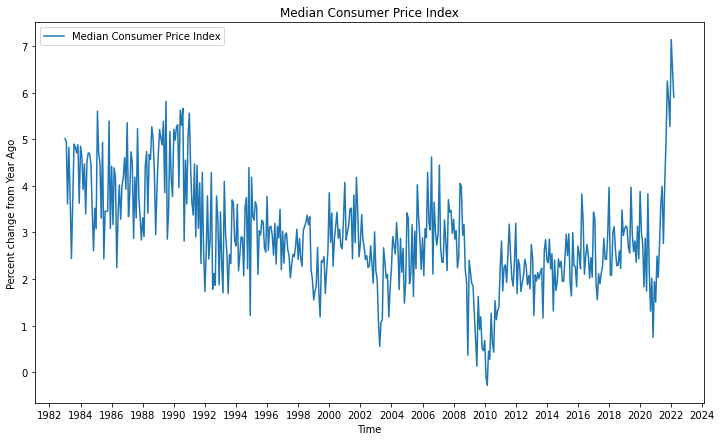

In [8]:
plt.figure(figsize = (12, 7))

plt.plot(cpicore['date'], cpicore['MEDCPIM158SFRBCLE'],
         label='Median Consumer Price Index')
# plt.axhline(y = 4.551815, color = 'r', linestyle = '--')
plt.title("Median Consumer Price Index")

# plt.axvspan(dt.date(1978,1,3), dt.date(1982,1,3), color='r', alpha=0.4, lw=0)
# plt.text(dt.date(2022,1,3), 4.851815,'4.56%')
plt.ylabel('Percent change from Year Ago')
plt.xlabel('Time')
plt.gca().xaxis.set_major_locator(matplotlib.dates.YearLocator(base=2))
plt.legend()
plt.show()

### Moving Average Analysis

A moving analysis of the Median Consumer Price Index should give us a much clearer picture of the changes. Here, we are considering a moving average of 6 months.

          date  MEDCPIM158SFRBCLE
466 2021-11-01           5.855760
467 2021-12-01           5.275819
468 2022-01-01           7.141525
469 2022-02-01           6.506399
470 2022-03-01           5.902594


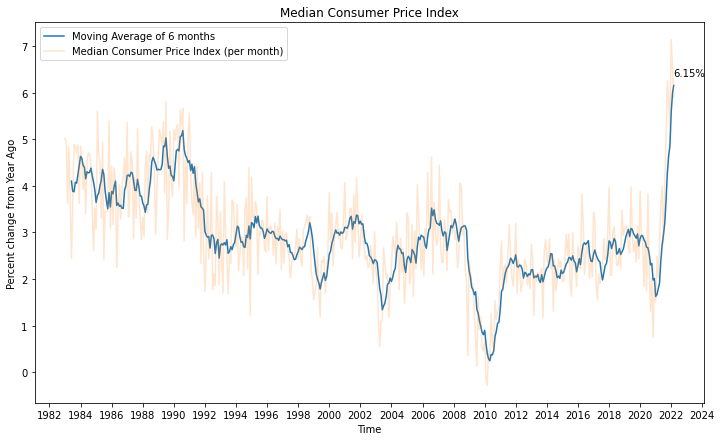

In [9]:
print(cpicore.tail())

cpicore['Y_Predict'] = cpicore.iloc[:,1].rolling(window=6).mean()

plt.figure(figsize = (12, 7))

plt.plot(cpicore['date'], cpicore['Y_Predict'], label='Moving Average of 6 months')
plt.plot(cpicore['date'], cpicore['MEDCPIM158SFRBCLE'], label='Median Consumer Price Index (per month)', alpha=0.2)


plt.title("Median Consumer Price Index")
plt.text(dt.date(2022,3,1), 6.355622,'6.15%')
plt.ylabel('Percent change from Year Ago')
plt.xlabel('Time')
plt.gca().xaxis.set_major_locator(matplotlib.dates.YearLocator(base=2))
plt.legend()
plt.show()

### Producer Price Index by Industry: General Freight Trucking, Long-Distance Truckload

The Producer Price Index (PPI) program measures the average change over time in the selling prices received by domestic producers for their output. The prices included in the PPI are from the first commercial transaction for many products and some services.

It is usually believed that CPI indicator laggs behind PPI. The comparison is made by indexing the 2003 values as 100.

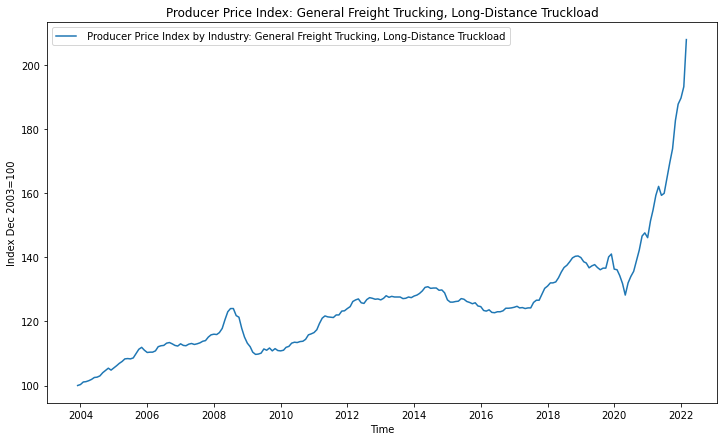

In [124]:
plt.figure(figsize = (12, 7))
plt.plot(ppifreghttruck['date'], ppifreghttruck['PCU484121484121'], label=' Producer Price Index by Industry: General Freight Trucking, Long-Distance Truckload')

plt.title("Producer Price Index: General Freight Trucking, Long-Distance Truckload")
plt.ylabel('Index Dec 2003=100')
plt.xlabel('Time')
plt.legend()
plt.show()